In [14]:
import ns_model
import warnings
import importlib
import numpy as np
import pandas as pd
from time import time
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit, fsolve, minimize

warnings.filterwarnings('ignore')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [5]:
importlib.reload(ns_model)
df1 = pd.read_csv('pulsar_data\\QHC18.csv')                   # equation of state
df2 = pd.read_csv('pulsar_data\\free_neutron.csv')            # equilibrium nucleus data
df3 = pd.read_csv('pulsar_data\\glitch_data.csv')             # Jodrell bank glitch database
df4 = pd.read_csv('pulsar_data\\pulsar_glitch_profile.csv')   # ATNF pulsar database 1
df5 = pd.read_csv('pulsar_data\\pulsar_glitch_dist.csv')      # ATNF pulsar database 2

In [6]:
class fit_routine:
    def __init__(self, emph, data, p0_range):
        self.emph = emph
        self.data = data
        self.p0_range = p0_range
        self.bands = [(2.27002, 2.2710), (2.26972, 2.26983), (2.2691,2.26965)]
    
    @staticmethod
    def get_k1(Tl, Tn, n1, dO1, dO, O_, MoI):
        # glitch equation 2 (relating jump in frequency to spin-down rate)
        Ic, Il, In = MoI
        return -(dO1/dO + 1/Tl + 1/Tn*(1+Ic/In))/(n1 * O_**(n1-1))
    
    @staticmethod
    def get_k0(dO1, k1, n0, n1, O_):
        # glitch equation 1 (glitch trigger)
        return (dO1 + k1*O_**n1)/O_**n0
    
    @staticmethod
    def fit_steady(x, Tl, Tn, k, n, MoI):
        # steady-state equation 
        Ic, Il, In = MoI
        I_t = Ic+Il+In
        syi, phi = (Tl*Il**2 + Tn*In**2)/(Ic*I_t), I_t/Ic
        return (n * syi/x + phi/(k*x**n))
    
    
    def run_sim(self, inputs, nsm_i):
        # run two year simulation 
        params = {'t_lim': [6.5e7, 1000], 'stress_amp': 1e8, 'sq_param': [0,0], 'nc_param:': [0,0,0]}
        Tl, Tn, n0, n1, k0, k1 = inputs
        n_, k_ = [n0, n1], [k0, k1]
        single_glitch = {'t0': 57920, 'tg': 58064.555, 'dO': 9.61327e-05, 'O': 29.6413215497439 * 2*np.pi,
                         'k':k_, 'n':n_, 'Tl': [Tl, Tl], 'Tn': [Tn, Tn], 'source':'ns'}  
        out = nsm_i.run_sim('0534+2200', params=params, glitch_on=[False,False,True], steady=True,
                          single_glitch=single_glitch, verbose=False, rise_time=0)
        r_lim = 1.6e-6
        res_ = nsm_i.get_residuals(out, self.data.values.T, r_lim, res=True)
        return res_
    
    @staticmethod
    def get_ns(central_dens):
        # get neutron star structure
        np.random.seed(815)
        ns_inputs = {'central_density': central_dens, 'proton_frac': 0.05}
        nsm = ns_model.NeutronStar(df1, df2, df3, df4, df5, ns_inputs, verbose=False)
        In, Ic, Il, I = nsm.moi_.values()
        return [nsm, [Ic, Il, In]]

    def run_fit(self, O_, dO, dO1, MoI, g_, Tl_0=0.7e7, Tn_0=1.1e8): 
        # run fit routine
        o_ = 2*np.pi
        Xn_, Yn_ = self.emph.f0*o_, self.emph.f1*o_
        y1 = Yn_[(Xn_ > 10**self.bands[g_][0]) & (Xn_ < 10**self.bands[g_][1])]
        x1 = Xn_[(Xn_ > 10**self.bands[g_][0]) & (Xn_ < 10**self.bands[g_][1])]
        y1 = -1/y1
        y2 = Yn_[(Xn_ > 10**self.bands[g_+1][0]) & (Xn_ < 10**self.bands[g_+1][1])]
        x2 = Xn_[(Xn_ > 10**self.bands[g_+1][0]) & (Xn_ < 10**self.bands[g_+1][1])]
        y2= -1/y2
        comboY = np.append(y1, y2)
        comboX = np.append(x1, x2)
        
        def combinedFunction(comboData, Tl, Tn, n0, n1, get_data=False):
            Tl, Tn = abs(Tl), abs(Tn)

            extract1 = comboData[:len(x1)] # first data
            extract2 = comboData[len(x1):] # second data

            k1 = self.get_k1(Tl, Tn, n1, dO1, dO, O_, MoI)
            k0 = self.get_k0(dO1, k1, n0, n1, O_)

            result1 = self.fit_steady(extract1, Tl, Tn, k0, n0, MoI)
            result2 = self.fit_steady(extract2, Tl, Tn, k1, n1, MoI)
            res =  np.append(result1, result2) if (not get_data) else (Tl, Tn, n0, n1, k0, k1)
            return res

        p0 = np.array([Tl_0, Tn_0, 2.5, 2.5])
        bounds= [[1e5, 1e6, 2.0, 2.0], [1e8, 1e10, 3.0, 3.0]]
        try:
            out_com = curve_fit(combinedFunction, comboX, comboY, maxfev=10000, p0=p0, bounds=bounds)
        except RuntimeError:
            return [0], [1]
        else:
            sols_c = combinedFunction(comboX, *out_com[0], get_data=True)
            return sols_c, np.sqrt(np.diag(out_com[1]))
        
    def pipeline(self):
        # run pipeline
        O_, dO = 186.2135, 9.6155e-5
        dO1, ddO1 = -1.6141e-11, 0.0049e-11
        res = []
        res_err = []
        vals = []
        vals_err= []
        struts = []
        for central_dens in self.p0_range:
            t1 = time()
            print(central_dens)
            nsm_i, MoI = self.get_ns(central_dens)
            pars_mean, e_ = self.run_fit(O_, dO, dO1, MoI, g_=0) # Tl, Tn, n0, n1, k0, k1
            pars_p, e_p = self.run_fit(O_, dO, dO1+ddO1, MoI, g_=0)
            pars_m, e_m = self.run_fit(O_, dO, dO1-ddO1, MoI, g_=0)
            if (pars_mean[0] > e_[0]) and (pars_p[0] > e_p[0]) and (pars_m[0] > e_m[0]):
                vals.append(np.mean([pars_mean, pars_p, pars_m], axis=0))
                vals_err.append(np.std([pars_mean, pars_p, pars_m], axis=0))
                struts.append(list(nsm_i.profile.values()))
                res_mean = self.run_sim(pars_mean, nsm_i)
                res_p = self.run_sim(pars_p, nsm_i)
                res_m = self.run_sim(pars_m, nsm_i)
                res.append(np.mean([res_mean, res_p, res_m]))
                res_err.append(np.std([res_mean, res_p, res_m]))
            else:
                print('failed')
                res.append(np.nan)
                res_err.append(np.nan)
                vals.append(np.nan)
                struts.append(np.nan)
                vals_err.append(np.nan)
            print(time() - t1)
        return [self.p0_range, np.array(res), np.array(res_err), np.array(vals), \
                np.array(struts) , np.array(vals_err)]

In [1]:
# run simulations
data_ = pd.read_csv('./timing_data/crabemph.csv')
data_1 =  pd.read_csv('stride_fit1.csv', index_col=0)
p0_ = np.linspace(2.7, 3.5, 40)
fr_ = fit_routine(data_, data_1, p0_)
out_pipe = fr_.pipeline()

In [8]:
# collect simulation data
x_, y_, y_err = pd.DataFrame(out_pipe[:3]).T.dropna().values.T
params = out_pipe[3][~np.isnan(out_pipe[2])]
strut = out_pipe[4][~np.isnan(out_pipe[2])]
par_val = out_pipe[5][~np.isnan(out_pipe[2])]

x_ = x_.astype(float)
y_ = y_.astype(float)
y_err = y_err.astype(float)

params_1 = np.array([list(row) for row in params])
params_err_1 = np.array([list(row) for row in par_val])
strut_1 = np.array([list(row) for row in strut])

Tl, Tn, n0, n1, k0, k1 = params_1.T
dTl, dTn, dn0, dn1, dk0, dk1 = params_err_1.T
r, crust, core, mass = strut_1.T

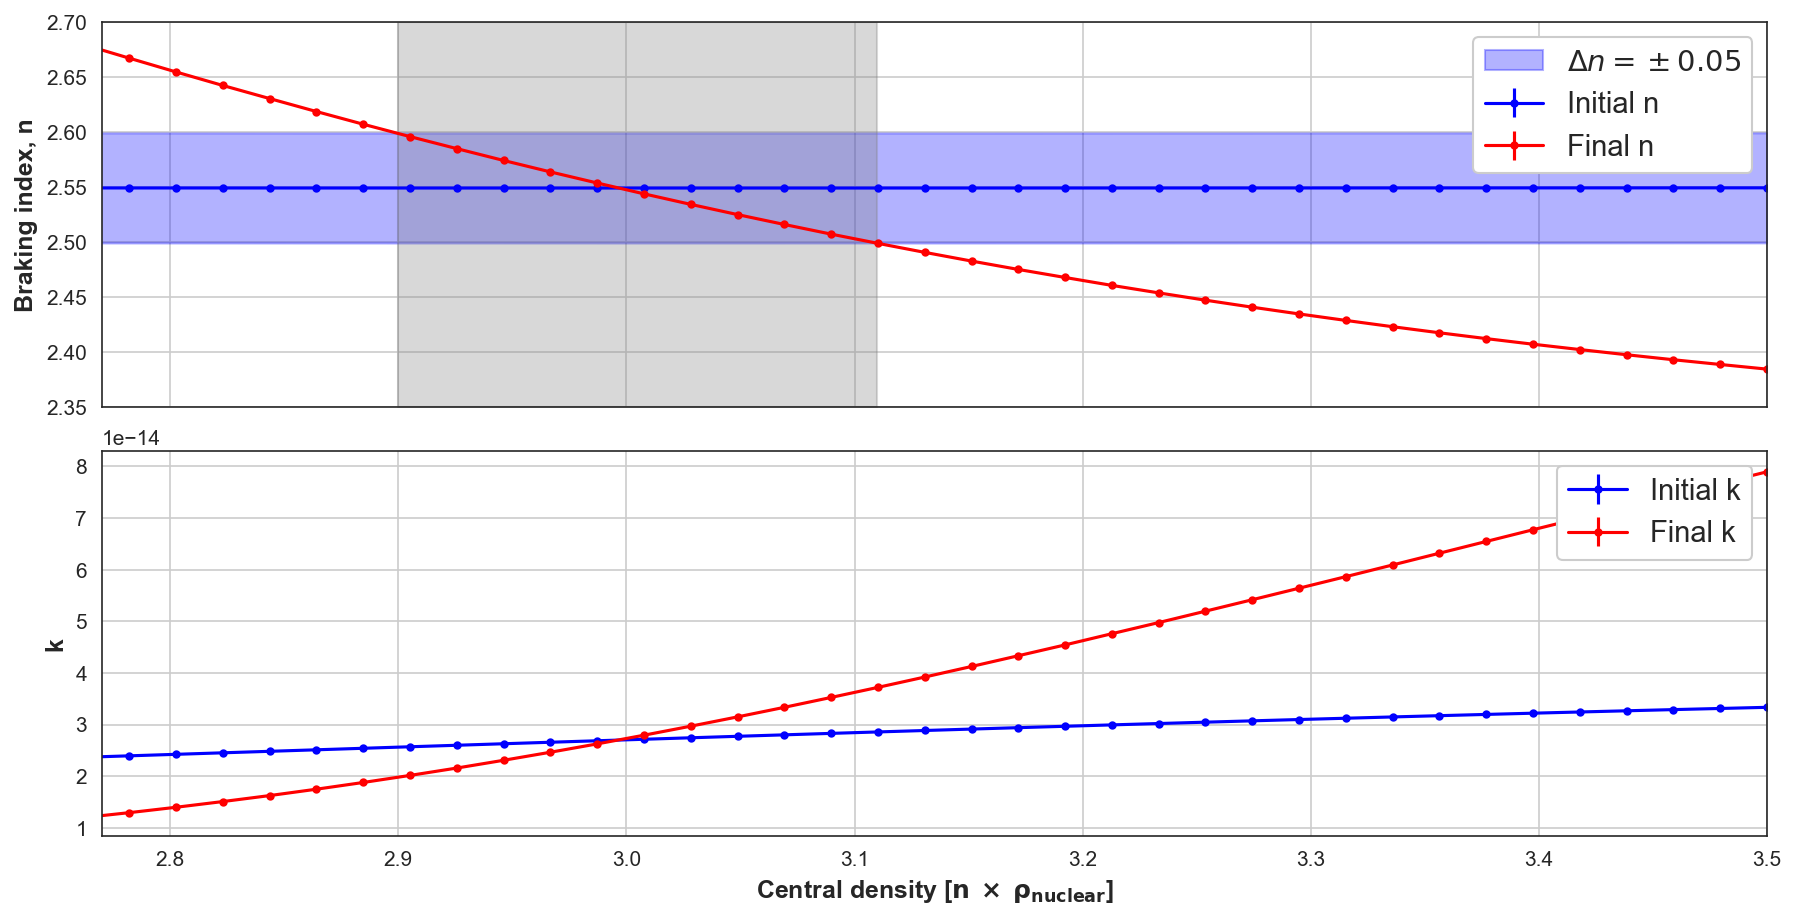

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 6), sharex=True, dpi=150)
ax1.errorbar(x=x_, y=n0, yerr=dn0, fmt='b.-', label='Initial n')
ax1.errorbar(x_, n1, dn1, fmt='r.-', label='Final n')
ax1.fill_between(x_, n0+0.05, n0-0.05, color='blue', alpha=0.3, label=r'$\Delta n = \pm 0.05$')

ax1.fill_between(x=[2.9, 3.11], y1=2.35, y2=2.7, color='gray', alpha=0.3)
ax1.set_ylim(2.35, 2.7)
ax1.set_xlim([2.77, 3.5])
ax1.set_ylabel('Braking index, n', fontsize=12, weight='bold')
ax1.legend(fontsize=14, loc=1, framealpha=1)

ax2.errorbar(x_, k0, dk0,  fmt='b.-', label='Initial k')
ax2.errorbar(x_, k1, dk1, fmt='r.-',  label='Final k')
ax2.set_ylabel('k', fontsize=12, weight='bold')
ax2.set_xlabel(r'Central density [$\mathbf{n\:\times\:\rho_{nuclear} }$]', fontsize=12, weight='bold')
ax2.legend(fontsize=14, loc=1, framealpha=1)
plt.tight_layout()
ax1.grid()
ax2.grid()

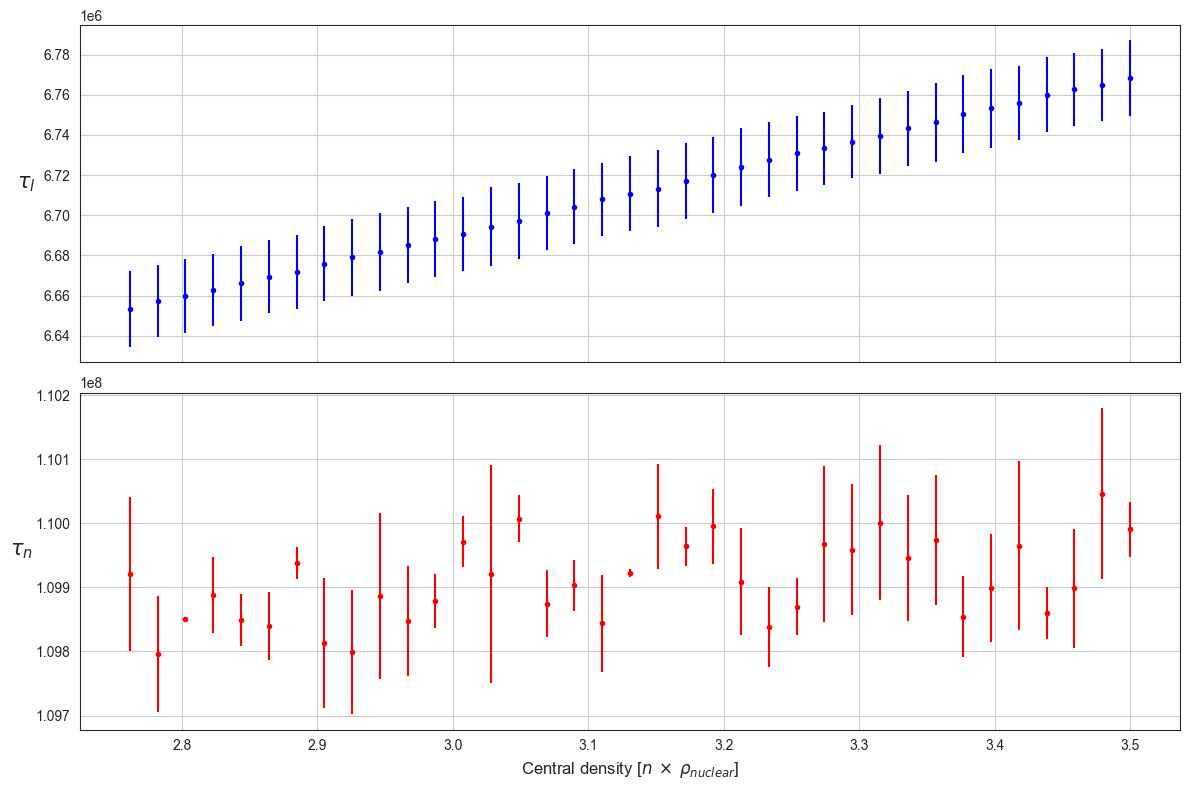

In [10]:
fig, (ax1, ax2)= plt.subplots(nrows=2, figsize=(12, 8), dpi=100, sharex=True)
ax1.errorbar(x_, Tl, dTl, fmt='b.')
ax2.errorbar(x_, Tn, dTn, fmt='r.')
ax1.set_ylabel(r'$\tau_l$', fontsize=15, rotation=0, labelpad=12)
ax2.set_ylabel(r'$\tau_n$', fontsize=15, rotation=0, labelpad=10)
ax2.set_xlabel(r'Central density [$n\:\times\:\rho_{nuclear} $]', fontsize=12)
ax1.grid()
ax2.grid()
plt.tight_layout()

In [30]:
def get_sims(p0_arr):
    out_list = []
    for p0i in p0_arr:
        fr_ = fit_routine(data_, data_1, p0_)
        nsm, MoI = fr_.get_ns(p0i)
        print(nsm.profile)
        print(MoI)

        O_, dO = 186.2135, 9.61327e-05
        dO1, ddO1 = -1.6141e-11, 0.0049e-11
        pars_mean, e_ = fr_.run_fit(O_, dO, dO1, MoI, g_=0) 
        print(pars_mean) # Tl, Tn, n0, n1, k0, k1
        
        params = {'t_lim': [6.5e7, 1000], 'stress_amp': 1e8, 'sq_param': [0,0], 'nc_param:': [0,0,0]}
        Tl, Tn, n0, n1, k0, k1 = pars_mean
        n_, k_= [n0, n1], [k0, k1]

        single_glitch = {'t0': 57920, 'tg': 58064.555, 'dO': dO, 'O': 29.6413215497439 * 2*np.pi,
                         'k':k_, 'n':n_, 'Tl': [Tl, Tl], 'Tn': [Tn, Tn], 'source':'ns'}  
        t1 = time()
        out_ = nsm.run_sim('0534+2200', params=params, glitch_on=[False,False,True], steady=True,
                          single_glitch=single_glitch, verbose=True, rise_time=0)
        print(time()-t1)
        
        out_list.append(out_)
    return out_list

def plot_sim(out, col, val):
    O1c = out['dOc']
    O1l = out['dOl']
    O1n = out['dOn']
    sg = out.get('sg')
    start_year = Time(sg['t0'], format='mjd').jyear
    t = Time(start_year + out['t']*u.s.to(u.year), format='jyear').datetime
    units = r'$\rho_{nuclear}$'
    ax.plot(t, O1c, c=col, lw=2.5, label='Charged component', alpha=0.7)
    ax.plot(t, O1n, c='red', lw=2, ls='-', label='Neutron superfluid', alpha=0.5)
    ax.plot(t, O1l, c='lime', lw=2, ls='-', label='Core', alpha=0.5)

In [12]:
out1, out2, out3 = get_sims([2.9, 3.0, 3.1])

{'surface': 11675.939405786825, 'crust': 11041.862734939577, 'core': 9293.154775331295, 'mass': 0.9873443238437231}
[1.0185281426269514e+37, 4.809383701657229e+37, 1.0628353586977059e+37]
(6674732.065446479, 109614845.4492902, 2.5492584237264215, 2.5988338517056, 2.5630177121473507e-14, 1.9799827557981883e-14)
0 -1.6979176277785414e-11
0.19213847692307692 single glitch
0.9999846461538462 restart
2.219808340072632
{'surface': 11651.4150159102, 'crust': 11059.935138692827, 'core': 9419.936677394693, 'mass': 1.0412387391133224}
[1.0281200372371743e+37, 5.279589995893644e+37, 1.032140005943599e+37]
(6687809.504421108, 109973350.49186637, 2.549242248189221, 2.547628115385722, 2.7048709357402658e-14, 2.730447618429052e-14)
0 -1.70117009645917e-11
0.19213847692307692 single glitch
0.9999846461538462 restart
1.6216638088226318
{'surface': 11629.658805869709, 'crust': 11078.037121855386, 'core': 9530.618775833582, 'mass': 1.0935329070644035}
[1.0364823954623327e+37, 5.740556191310976e+37, 1.002

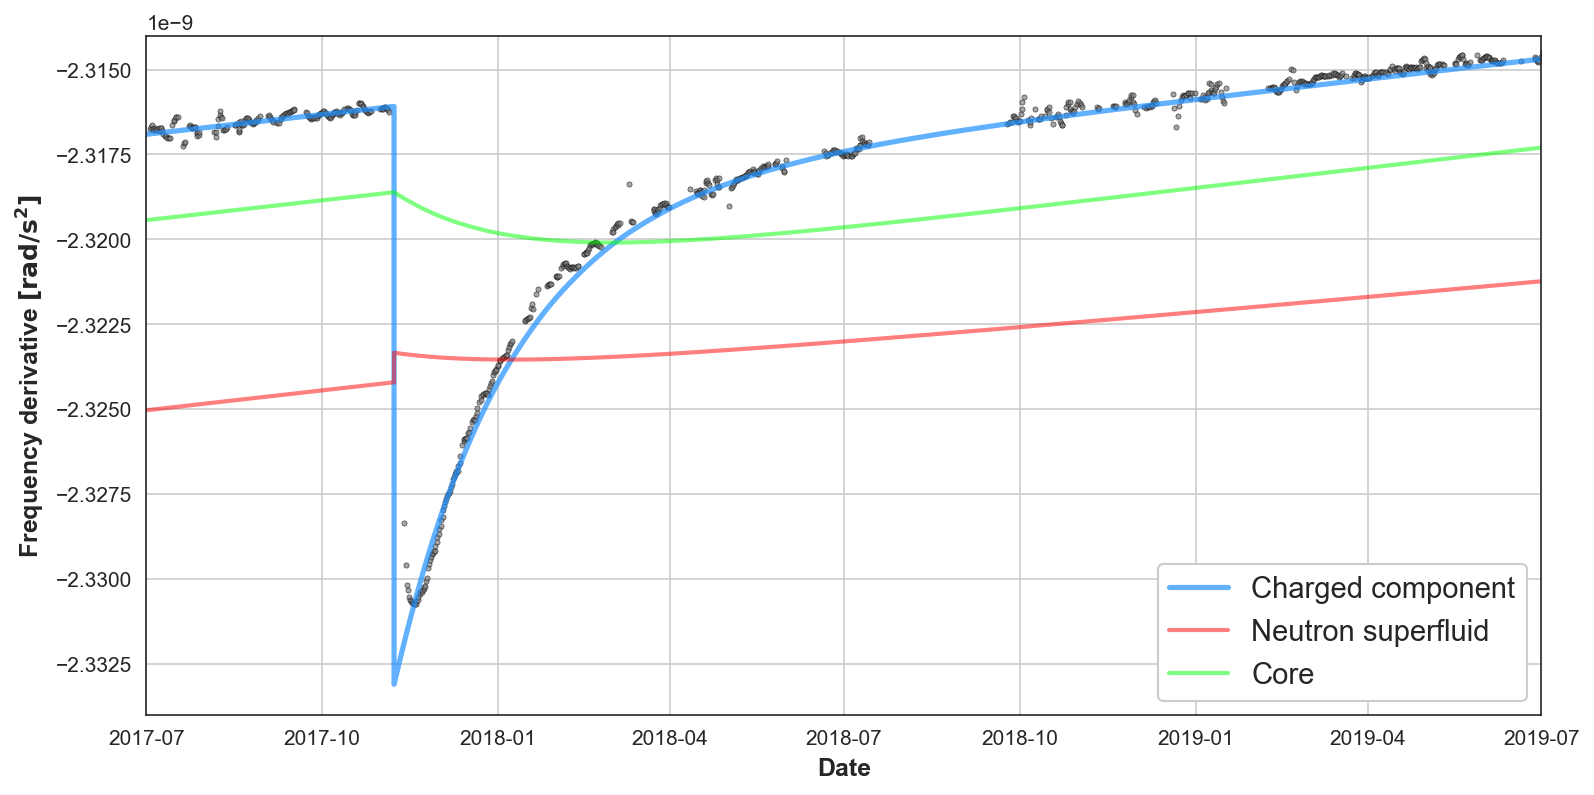

In [33]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
out_c = data_1.values.T
r_lim = 1.6e-6
t_i = out_c[2][abs(out_c[3]) < r_lim]
df_i = out_c[1][abs(out_c[3]) < r_lim]
ax.plot(Time(t_i, format='mjd').datetime, 2*np.pi*df_i, 'k.',c='gray', 
        markersize=5, mew=0.3, mec='k', alpha=0.7)
ax.set_ylim([-2.334e-9, -2.314e-9])
ax.set_xlim([Time('2017-7-1').datetime, Time('2019-7-1').datetime])

ax.set_ylabel(r'Frequency derivative $\mathbf{[rad/s^2]}$', fontsize=12, weight='bold')
ax.set_xlabel('Date', fontsize=12, weight='bold')

plot_sim(out2, 'dodgerblue', '2.9')
ax.legend(fontsize=14, loc=4, framealpha=1)
ax.grid()
